# Generative Model (NIR beers dataset)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.8


In [2]:
# import local utility functions and classes
import sys
sys.path.append('../utils')
import models as mdl
import utils as utl
from data import Data

## Load raw data and plot

In [3]:
# init data object
data_obj = Data('../../data/beers/NIR_beers.csv', 'label', -1)
data = data_obj.data
data.head(5)

,1,2,3,4,5,6,7,8,9,10,...,692,693,694,695,696,697,698,699,700,label
37,-0.002702,-0.002589,-0.002469,-0.002357,-0.002263,-0.002178,-0.002092,-0.002007,-0.001918,-0.001821,...,0.681876,0.687409,0.692493,0.697092,0.701362,0.705330,0.708713,0.711816,0.714572,2
24,0.082634,0.082764,0.082909,0.083050,0.083181,0.083316,0.083467,0.083618,0.083743,0.083857,...,0.775477,0.781133,0.786250,0.791007,0.795365,0.799252,0.802854,0.806068,0.808856,1
25,0.082543,0.082673,0.082815,0.082957,0.083087,0.083224,0.083383,0.083539,0.083664,0.083778,...,0.776522,0.782052,0.787064,0.791726,0.796006,0.799876,0.803458,0.806597,0.809245,1
36,0.084691,0.084817,0.084956,0.085100,0.085233,0.085357,0.085497,0.085652,0.085798,0.085930,...,0.767531,0.772918,0.777904,0.782356,0.786504,0.790316,0.793723,0.796759,0.799428,1
34,-0.003401,-0.003281,-0.003153,-0.003031,-0.002922,-0.002821,-0.002724,-0.002629,-0.002529,-0.002418,...,0.680850,0.686305,0.691412,0.696080,0.700388,0.704347,0.707879,0.710993,0.713759,1


1: blue
2: red


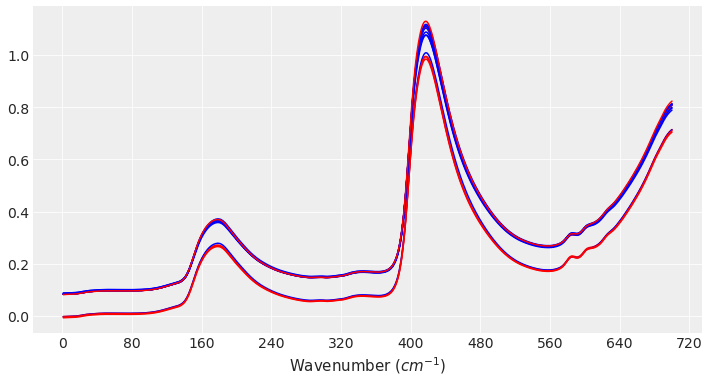

In [4]:
# name of column containing the labels
label_col = data_obj.label_column

# number of non-data columns at right of dataframe
non_data_cols = data_obj.non_data_columns

# list of class labels
class_labels = data_obj.get_class_labels()

# plot dataframe
utl.plot_data(data_obj, 15)

In [5]:
# number of samples from each class
data[label_col].value_counts()

1    28
2    16
Name: label, dtype: int64

In [6]:
# store the data values for all different classes
df = [data.query("label ==  @class_labels[@i]") for i in range(len(class_labels))]

x_n = data.columns[:non_data_cols]
x_s = [df[i][x_n].values for i in range(len(df))]

# Model definition

The following model is assumed:

\begin{equation}
\mu_{m} \sim \text{LogNormal}(0, 1) \\
\sigma_{ab} \sim \Gamma(1, 1) \\
\sigma_{m} \sim |\mathcal{N}(0, \sigma^{2}_{ab})| \\
\mu \sim \mathcal{N}(\mu_{m},\sigma^{2}_{m}) \\
\sigma_{\sigma} \sim \Gamma(1, 1) \\
\sigma \sim |\mathcal{N}(0, \sigma^{2}_{\sigma})| \\
X_{a,b} \sim \mathcal{N}(\mu,\sigma^{2})
\end{equation}

In [7]:
# load model and run inference
nsamples = 16
genmod = mdl.generative_model(x_s, len(class_labels), len(x_n), nsamples=nsamples)

with genmod:
    trace_gm = pm.sample(2000, init='adapt_diag', tune=1000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, sigma_s, mu, sigma_mu, sigma_ab, mu_m]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:38<00:00, 155.13draws/s]


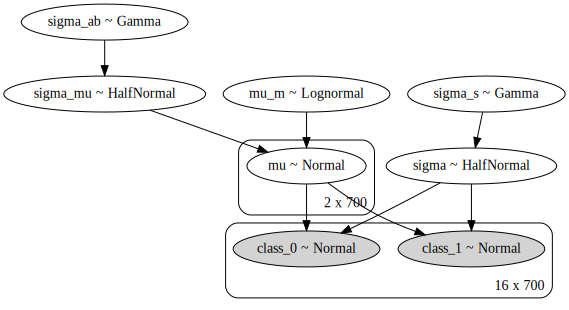

In [8]:
pm.model_to_graphviz(genmod)

In [9]:
az.summary(trace_gm)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"mu[0,0]",0.063,0.011,0.041,0.083,0.000,0.000,7562.0,7514.0,7565.0,2683.0,1.0
"mu[0,1]",0.063,0.011,0.043,0.084,0.000,0.000,7856.0,7340.0,7837.0,2637.0,1.0
"mu[0,2]",0.063,0.011,0.043,0.084,0.000,0.000,8629.0,7853.0,8632.0,2457.0,1.0
"mu[0,3]",0.063,0.011,0.043,0.084,0.000,0.000,9157.0,8750.0,9236.0,2436.0,1.0
"mu[0,4]",0.063,0.011,0.041,0.083,0.000,0.000,8598.0,8203.0,8589.0,2457.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
mu_m,0.297,0.006,0.286,0.310,0.000,0.000,7159.0,7153.0,7144.0,2689.0,1.0
sigma_ab,0.682,0.653,0.078,1.914,0.011,0.009,3375.0,2772.0,7498.0,2800.0,1.0
sigma_mu,0.238,0.005,0.230,0.247,0.000,0.000,7170.0,7118.0,7264.0,2623.0,1.0
sigma_s,0.366,0.508,0.017,1.220,0.009,0.007,3200.0,2995.0,6675.0,2939.0,1.0


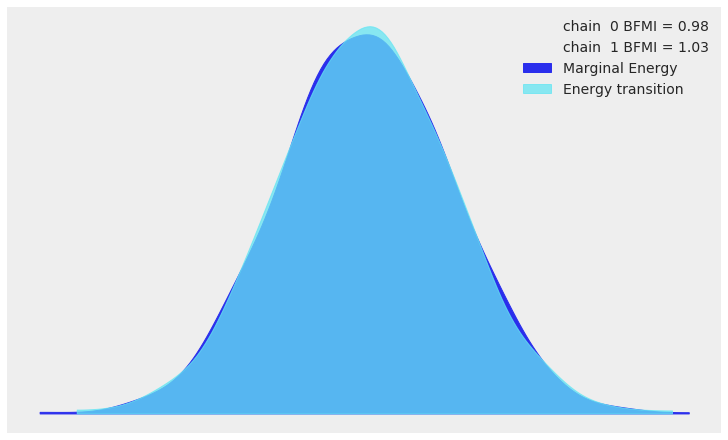

In [10]:
az.plot_energy(trace_gm, figsize=(10, 6));

In [11]:
ppc = pm.sample_posterior_predictive(trace_gm, samples=250, model=genmod)

/home/johan/VirtualEnv/ppsda/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 250/250 [00:01<00:00, 210.81it/s]


arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


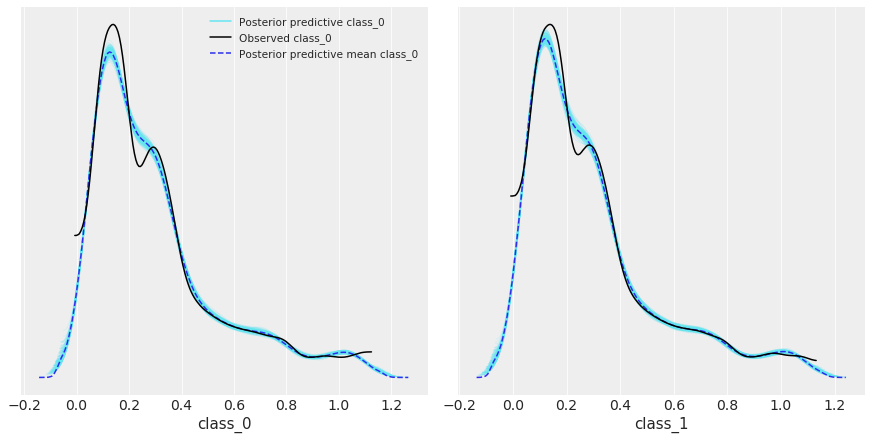

In [12]:
data_ppc = az.from_pymc3(trace=trace_gm, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)

In [13]:
print(az.r2_score(x_s[0][:nsamples], ppc['class_0']))

r2        0.964934
r2_std    0.003078
dtype: float64


In [14]:
print(az.r2_score(x_s[1][:nsamples], ppc['class_1']))

r2        0.964708
r2_std    0.003078
dtype: float64


In [15]:
print(az.bfmi(trace_gm))

[0.97971808 1.03493155]


# Posterior samples vs. mean data

In [16]:
# class samples from the posterior
cl_a = ppc['class_0']
cl_b = ppc['class_1']

ppc_class_lst = [cl_a, cl_b]

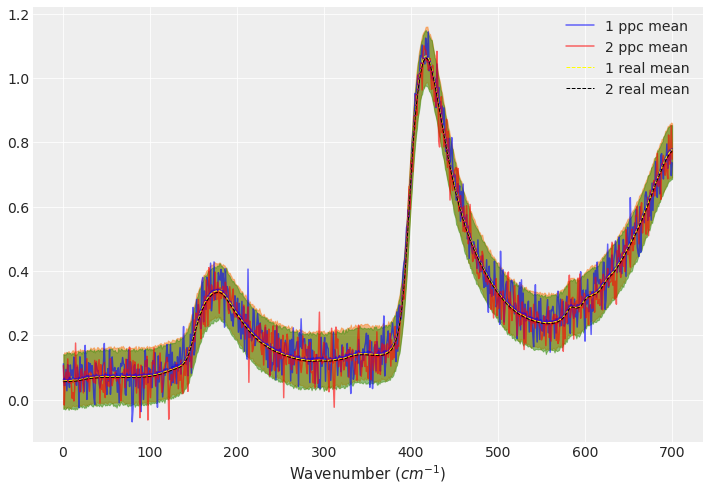

In [17]:
utl.plot_mean_vs_ppc(data_obj, ppc_class_lst)

# Real spectrum vs. posterior samples

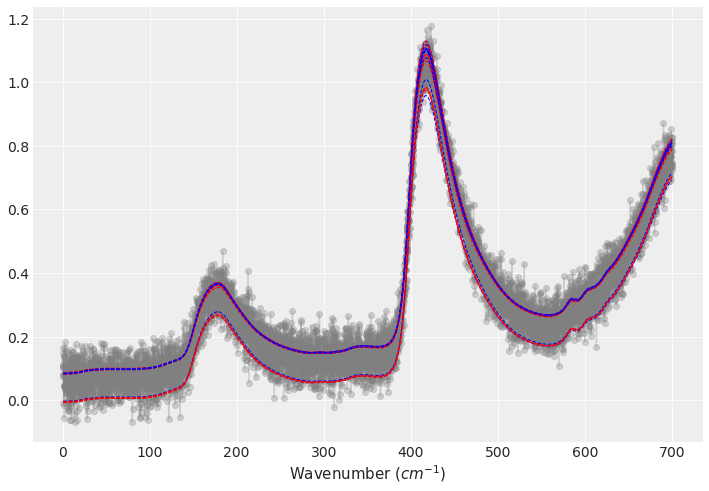

In [18]:
utl.plot_real_vs_ppc(data_obj, ppc_class_lst, 10)

# Save posterior samples to .csv file

In [19]:
utl.save_traces(data_obj, './ppc_samples_beers_nir.csv' , 100, ppc_class_lst)